In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import joblib

# Carregar o dataset
data = pd.read_csv('Data/Google-Playstore.csv', nrows=8000)

# Remover colunas indesejadas
data = data.drop(['App Name', 'App Id', 'Minimum Installs', 'Maximum Installs', 'Currency',
                  'Developer Id', 'Developer Website', 'Developer Email', 'Released',
                  'Last Updated', 'Privacy Policy', 'Scraped Time'], axis=1)

# Remover linhas onde a variável alvo 'Installs' é nula
data = data.dropna(subset=['Installs'])

# Tratar a coluna 'Installs'
data['Installs'] = data['Installs'].str.replace('[+,]', '', regex=True)
data['Installs'] = pd.to_numeric(data['Installs'], errors='coerce').astype('Int64')

def handle_missing_values(df):
    df['Category'].fillna(df['Category'].mode()[0], inplace=True)
    df['Rating'].fillna(df['Rating'].mean(), inplace=True)
    df['Rating Count'].fillna(df['Rating Count'].mean(), inplace=True)
    df['Free'].fillna(True, inplace=True)
    df['Price'].fillna(0.0, inplace=True)
    df['Size'] = df['Size'].apply(size_to_mb)
    df['Size'].fillna(df['Size'].mean(), inplace=True)
    df['Minimum Android'].fillna(df['Minimum Android'].mode()[0], inplace=True)
    df['Content Rating'].fillna(df['Content Rating'].mode()[0], inplace=True)
    df['Ad Supported'].fillna(True, inplace=True)
    df['In App Purchases'].fillna(False, inplace=True)
    df['Editors Choice'].fillna(False, inplace=True)

def size_to_mb(size):
    if pd.isna(size):
        return np.nan
    if isinstance(size, str):
        if 'M' in size or 'm' in size:
            return float(size.replace('M', '').replace('m', '').replace(',', '.'))
        elif 'K' in size or 'k' in size:
            return float(size.replace('K', '').replace('k', '').replace(',', '.')) / 1024
        elif 'G' in size or 'g' in size:
            return float(size.replace('G', '').replace('g', '').replace(',', '.')) * 1024
    return np.nan

def parse_android_version(version):
    if pd.isna(version):
        return np.nan
    if 'Varies with device' in version:
        return np.nan
    if 'and up' in version:
        version = version.replace('and up', '').strip()
    if '-' in version:
        version = version.split('-')[0].strip()
    version = version.replace('W', '').strip()
    try:
        return float(version)
    except ValueError:
        return np.nan

handle_missing_values(data)
data['Minimum Android'] = data['Minimum Android'].apply(parse_android_version)
mean_android_version = data['Minimum Android'].mean()
data['Minimum Android'].fillna(mean_android_version, inplace=True)

data['Rating Count'] = data['Rating Count'].astype(int)
data['Minimum Android'] = [int(x * 10) / 10 for x in data['Minimum Android']]

label_encoder_category = LabelEncoder()
label_encoder_content_rating = LabelEncoder()
data['Category'] = label_encoder_category.fit_transform(data['Category'])
category_mapping = dict(zip(label_encoder_category.classes_, label_encoder_category.transform(label_encoder_category.classes_)))
data['Content Rating'] = label_encoder_content_rating.fit_transform(data['Content Rating'])
content_mapping = dict(zip(label_encoder_content_rating.classes_, label_encoder_content_rating.transform(label_encoder_content_rating.classes_)))

# Preparação dos dados
X = data[['Category', 'Rating','Rating Count', 'Free','Price','Size','Minimum Android','Content Rating', 'Ad Supported','In App Purchases','Editors Choice']]
y = data['Installs']

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Função para avaliar o modelo
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Model: {name}")
    print(f"R^2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}\n")
    return model

In [2]:
models = {}

In [3]:
models['Linear Regression'] = evaluate_model('Linear Regression', LinearRegression(), X_train, y_train, X_test, y_test)

Model: Linear Regression
R^2: 0.7605
MAE: 122656.3307
MSE: 1608324472393.4890
RMSE: 1268197.3318


In [4]:
models['Ridge Regression'] = evaluate_model('Ridge Regression', Ridge(alpha=1.0), X_train, y_train, X_test, y_test)

Model: Ridge Regression
R^2: 0.7604
MAE: 122947.1963
MSE: 1608926612438.5813
RMSE: 1268434.7096


In [5]:
models['Lasso Regression'] = evaluate_model('Lasso Regression', Lasso(alpha=1.0), X_train, y_train, X_test, y_test)

Model: Lasso Regression
R^2: 0.7605
MAE: 122655.1847
MSE: 1608326282876.2549
RMSE: 1268198.0456


In [6]:
#models['Logistic Regression'] = evaluate_model('Logistic Regression', LogisticRegression(), X_train, y_train, X_test, y_test)

In [7]:
models['SVR (linear kernel)'] = evaluate_model('SVR (linear kernel)', SVR(kernel='linear'), X_train, y_train, X_test, y_test)

Model: SVR (linear kernel)
R^2: 0.6397
MAE: 100374.2236
MSE: 2419726810769.4692
RMSE: 1555547.1098


In [8]:
models['SVR (rbf kernel)'] = evaluate_model('SVR (rbf kernel)', SVR(kernel='rbf'), X_train, y_train, X_test, y_test)

Model: SVR (rbf kernel)
R^2: -0.0032
MAE: 146634.7710
MSE: 6736969995509.6279
RMSE: 2595567.3745


In [9]:
models['K-NN'] = evaluate_model('K-NN', KNeighborsRegressor(n_neighbors=2), X_train, y_train, X_test, y_test)

Model: K-NN
R^2: 0.6011
MAE: 112057.1084
MSE: 2678711175340.8379
RMSE: 1636676.8696


In [10]:
models['Decision Tree'] = evaluate_model('Decision Tree', DecisionTreeRegressor(), X_train, y_train, X_test, y_test)

Model: Decision Tree
R^2: 0.1727
MAE: 142891.7641
MSE: 5555491041911.7852
RMSE: 2357008.9185


In [11]:
#models['K_Means'] = evaluate_model('K_Means', KMeans(n_clusters=4), X_train, y_train, X_test, y_test)

In [12]:
models['Random Forest'] = evaluate_model('Random Forest', RandomForestRegressor(n_estimators=200), X_train, y_train, X_test, y_test)

Model: Random Forest
R^2: 0.5846
MAE: 117361.7963
MSE: 2789650797930.2300
RMSE: 1670224.7747


In [13]:
models['Neural Network (single layer)'] = evaluate_model('Neural Network (single layer)', MLPRegressor(hidden_layer_sizes=(10000,), max_iter=10000), X_train, y_train, X_test, y_test)

Model: Neural Network (single layer)
R^2: 0.7586
MAE: 95850.5278
MSE: 1621063772012.0701
RMSE: 1273210.0267


In [14]:
models['Neural Network (multi layer)'] = evaluate_model('Neural Network (multi layer)', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000), X_train, y_train, X_test, y_test)

Model: Neural Network (multi layer)
R^2: 0.7589
MAE: 95970.3860
MSE: 1618991628104.0974
RMSE: 1272396.0186


In [15]:
# Salvar os modelos e os mapeamentos
# joblib.dump(models, 'models.pkl')
# joblib.dump(label_encoder_category, 'label_encoder_category.pkl')
# joblib.dump(label_encoder_content_rating, 'label_encoder_content_rating.pkl')
# joblib.dump(category_mapping, 'category_mapping.pkl')
# joblib.dump(content_mapping, 'content_mapping.pkl')
# 
# print("Modelos e mapeamentos salvos com sucesso.")


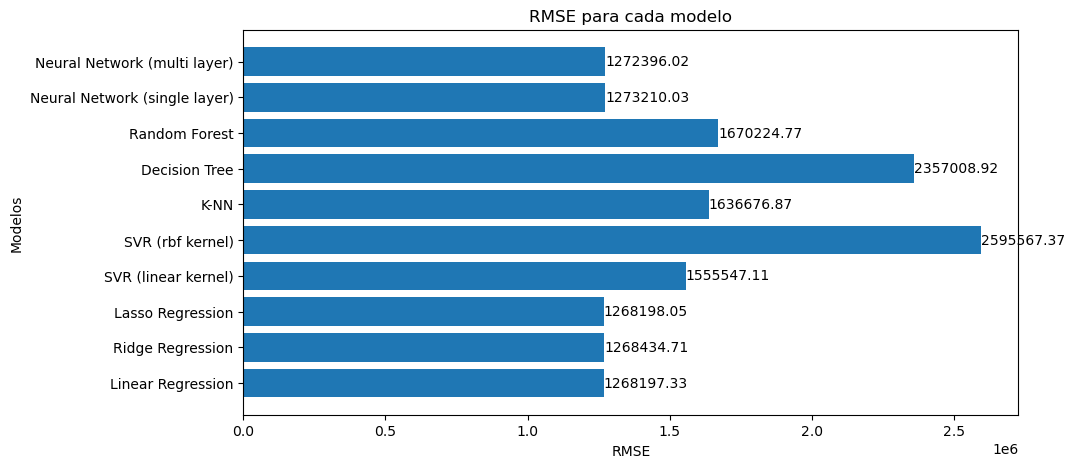

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Gerar gráfico de barras horizontais com os valores de RMSE obtidos para cada um dos modelos
rmse_values = {name: np.sqrt(mean_squared_error(y_test, model.predict(X_test))) for name, model in models.items()}

plt.figure(figsize=(10, 5))
bars = plt.barh(list(rmse_values.keys()), list(rmse_values.values()))
#Título do gráfico
plt.title('RMSE para cada modelo')
plt.xlabel('RMSE')
plt.ylabel('Modelos')

# Adicionar os valores de RMSE no final de cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2.0, f'{width:.2f}', ha='left', va='center')

plt.show()
